In [1]:
# %%
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression

import joblib
from pathlib import Path


In [2]:
sessions = pd.read_pickle('data/ga_sessions.pkl')
sessions.shape

(1860042, 18)

In [3]:
sessions.info()


<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 1860042 entries, 0 to 1860041
,Data columns (total 18 columns):
, #   Column                    Dtype 
,---  ------                    ----- 
, 0   session_id                object
, 1   client_id                 object
, 2   visit_date                object
, 3   visit_time                object
, 4   visit_number              int64 
, 5   utm_source                object
, 6   utm_medium                object
, 7   utm_campaign              object
, 8   utm_adcontent             object
, 9   utm_keyword               object
, 10  device_category           object
, 11  device_os                 object
, 12  device_brand              object
, 13  device_model              object
, 14  device_screen_resolution  object
, 15  device_browser            object
, 16  geo_country               object
, 17  geo_city                  object
,dtypes: int64(1), object(17)
,memory usage: 255.4+ MB


In [4]:
sessions.isna().mean().sort_values(ascending=False)


device_model                0.991216
utm_keyword                 0.581740
device_os                   0.575330
utm_adcontent               0.180434
utm_campaign                0.118063
device_brand                0.063804
utm_source                  0.000052
geo_country                 0.000000
device_browser              0.000000
device_screen_resolution    0.000000
session_id                  0.000000
device_category             0.000000
client_id                   0.000000
utm_medium                  0.000000
visit_number                0.000000
visit_time                  0.000000
visit_date                  0.000000
geo_city                    0.000000
dtype: float64

In [5]:
cols_to_drop = ['device_model', 'device_brand', 'utm_keyword', 'device_os']
sessions = sessions.drop(columns=cols_to_drop)


In [6]:
fill_other = [
    'utm_adcontent', 'utm_campaign', 'utm_medium', 'utm_source',
    'utm_keyword', 'device_os', 'device_brand', 'device_model',
    'geo_city'
]

fill_mode = [
    'device_category', 'device_browser', 'geo_country'
]


In [7]:
for col in fill_other:
    if col in sessions.columns:
        sessions[col] = sessions[col].fillna('other')


In [8]:
for col in fill_mode:
    if col in sessions.columns:
        mode_value = sessions[col].mode()[0]
        sessions[col] = sessions[col].fillna(mode_value)


In [9]:
sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,393x786,Chrome,Russia,Moscow


In [10]:

# Создаём datetime из даты и времени
sessions['visit_datetime'] = pd.to_datetime(
    sessions['visit_date'].astype(str) + ' ' + sessions['visit_time'].astype(str)
)

# Час визита (0–23)
sessions['visit_hour'] = sessions['visit_datetime'].dt.hour

# День недели (0=пн, 6=вс)
sessions['visit_weekday'] = sessions['visit_datetime'].dt.weekday

# Месяц визита
sessions['visit_month'] = sessions['visit_datetime'].dt.month

# Флаг выходного дня
sessions['is_weekend'] = sessions['visit_weekday'].isin([5, 6]).astype(int)


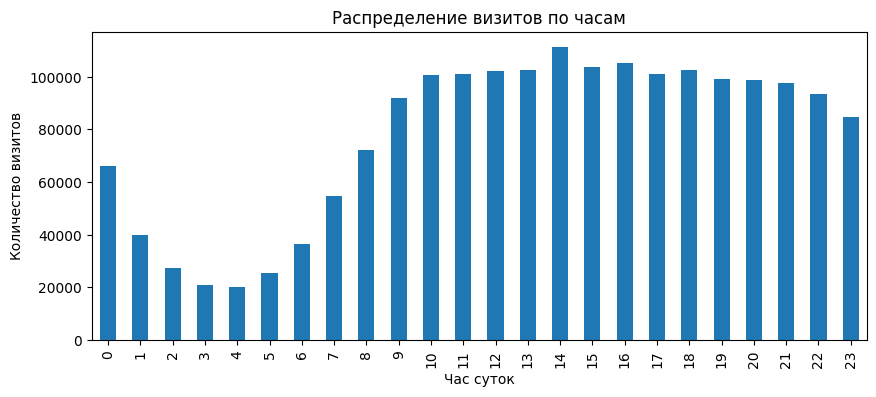

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sessions['visit_hour'].value_counts().sort_index().plot(kind='bar')
plt.title("Распределение визитов по часам")
plt.xlabel("Час суток")
plt.ylabel("Количество визитов")
plt.show()


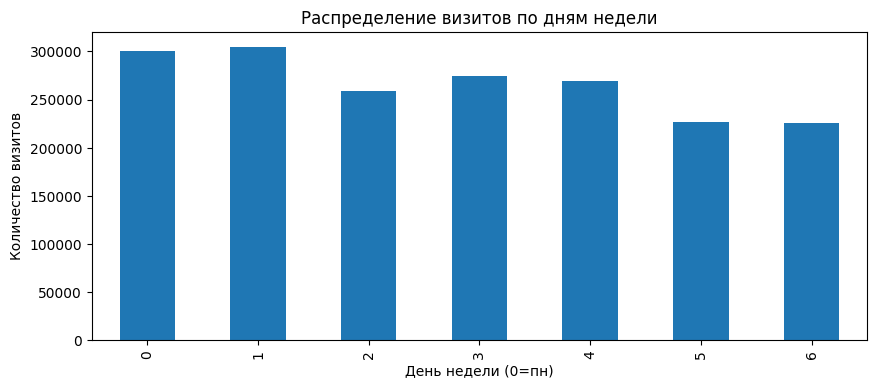

In [12]:
plt.figure(figsize=(10,4))
sessions['visit_weekday'].value_counts().sort_index().plot(kind='bar')
plt.title("Распределение визитов по дням недели")
plt.xlabel("День недели (0=пн)")
plt.ylabel("Количество визитов")
plt.show()


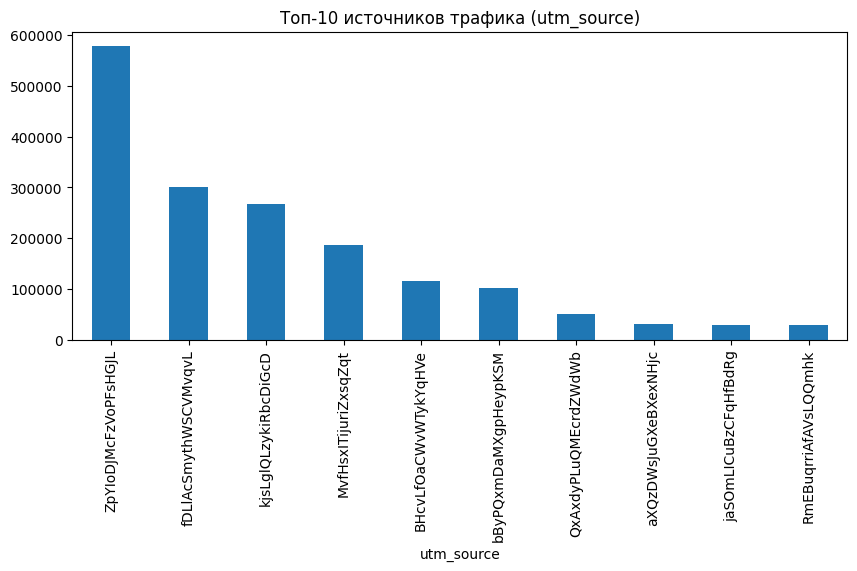

In [13]:
sessions['utm_source'].value_counts().head(10).plot(kind='bar', figsize=(10,4))
plt.title("Топ-10 источников трафика (utm_source)")
plt.show()


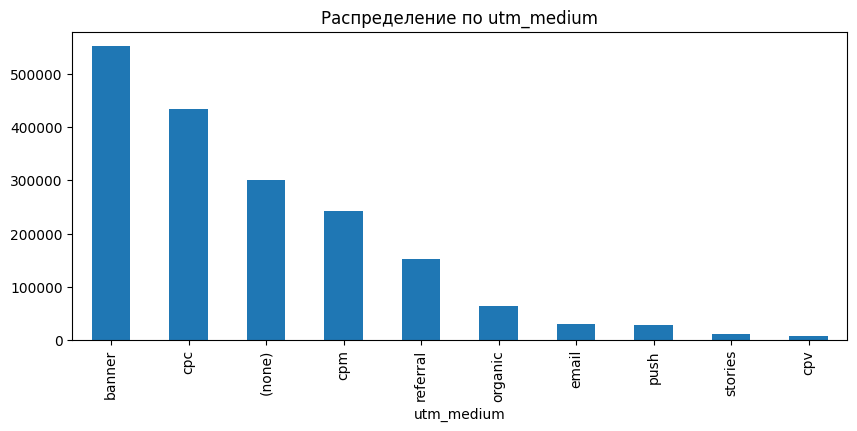

In [14]:
sessions['utm_medium'].value_counts().head(10).plot(kind='bar', figsize=(10,4))
plt.title("Распределение по utm_medium")
plt.show()


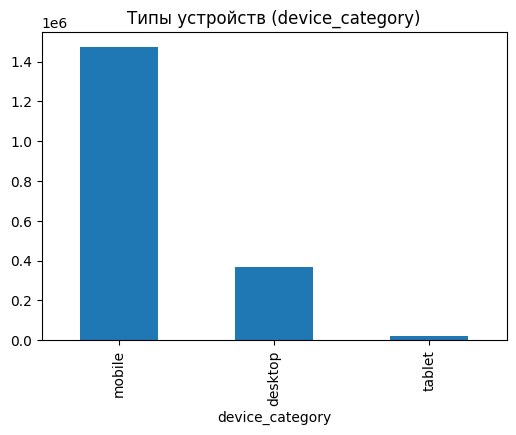

In [15]:
sessions['device_category'].value_counts().plot(kind='bar', figsize=(6,4))
plt.title("Типы устройств (device_category)")
plt.show()


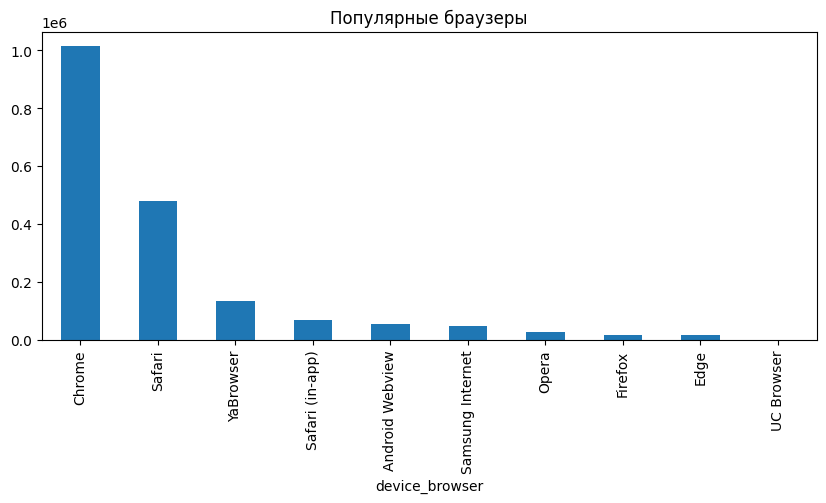

In [16]:
sessions['device_browser'].value_counts().head(10).plot(kind='bar', figsize=(10,4))
plt.title("Популярные браузеры")
plt.show()


In [17]:
# Финальные признаки, которые оставляем
final_columns = [
    'session_id', 'client_id',

    # временные признаки
    'visit_hour', 'visit_weekday', 'visit_month', 'is_weekend',

    # UTM
    'utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',

    # устройство
    'device_category', 'device_screen_resolution', 'device_browser',

    # география
    'geo_country', 'geo_city'
]

# Оставляем только нужные
sessions_final = sessions[final_columns].copy()

sessions_final.head()


,session_id,client_id,visit_hour,visit_weekday,visit_month,is_weekend,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,14,2,11,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,8,6,11,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2,1,12,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,5,5,5,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,5,5,5,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,393x786,Chrome,Russia,Moscow


In [18]:
import pandas as pd

hits = pd.read_pickle("data/hits_agg.pkl")
hits.head()


,session_id,hits,pageviews,events,target
0,5639623078712724064.1640254056.1640254056,38,0,0,0
1,7750352294969115059.1640271109.1640271109,45,0,0,0
2,885342191847998240.1640235807.1640235807,36,0,0,0
3,142526202120934167.1640211014.1640211014,38,0,0,0
4,3450086108837475701.1640265078.1640265078,64,0,0,0


In [19]:
df = sessions_final.merge(hits, on="session_id", how="left")
df["target"] = df["target"].fillna(0).astype(int)

df.head()


,session_id,client_id,visit_hour,visit_weekday,visit_month,is_weekend,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_screen_resolution,device_browser,geo_country,geo_city,hits,pageviews,events,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,14,2,11,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,360x720,Chrome,Russia,Zlatoust,2.0,0.0,0.0,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,8,6,11,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,385x854,Samsung Internet,Russia,Moscow,1.0,0.0,0.0,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2,1,12,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,360x720,Chrome,Russia,Krasnoyarsk,16.0,0.0,0.0,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,5,5,5,1,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,mobile,393x786,Chrome,Russia,Moscow,3.0,0.0,0.0,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,5,5,5,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,393x786,Chrome,Russia,Moscow,2.0,0.0,0.0,0


In [20]:
df.isna().mean().sort_values(ascending=False)


events                      0.068695
pageviews                   0.068695
hits                        0.068695
session_id                  0.000000
device_category             0.000000
geo_city                    0.000000
geo_country                 0.000000
device_browser              0.000000
device_screen_resolution    0.000000
utm_adcontent               0.000000
client_id                   0.000000
utm_campaign                0.000000
utm_medium                  0.000000
utm_source                  0.000000
is_weekend                  0.000000
visit_month                 0.000000
visit_weekday               0.000000
visit_hour                  0.000000
target                      0.000000
dtype: float64

In [21]:
df[['hits', 'pageviews', 'events']] = df[['hits', 'pageviews', 'events']].fillna(0)


In [22]:
df = df.drop(columns=['session_id', 'client_id'])


In [23]:
df.nunique().sort_values()


pageviews                      1
events                         1
target                         2
is_weekend                     2
device_category                3
visit_weekday                  7
visit_month                    8
visit_hour                    24
utm_medium                    56
device_browser                57
geo_country                  166
utm_adcontent                287
utm_source                   294
hits                         348
utm_campaign                 413
geo_city                    2548
device_screen_resolution    5039
dtype: int64

In [24]:
for col in ['utm_source', 'utm_campaign', 'utm_adcontent', 'geo_city', 'device_screen_resolution']:
    df[col] = df[col].map(df[col].value_counts())


In [28]:
import pandas as pd
import numpy as np

df = df.copy()

# ======================================================
# 1. Ограничение больших категорий (rare → other)
# ======================================================

def limit_categories(df, column, top_n):
    if column in df.columns:
        top_values = df[column].value_counts().head(top_n).index
        df[column] = df[column].where(df[column].isin(top_values), 'other')
    return df

df = limit_categories(df, 'geo_city', 50)
df = limit_categories(df, 'geo_country', 20)
df = limit_categories(df, 'utm_source', 50)
df = limit_categories(df, 'utm_campaign', 100)
df = limit_categories(df, 'utm_adcontent', 100)

print("✔ Ограничение категорий сделано")


# ======================================================
# 2. Парсер разрешения экрана (универсальный)
# ======================================================

def parse_resolution(res):
    if not isinstance(res, str):
        return np.nan, np.nan

    res = res.lower()

    for sym in ['×', '*', 'х', 'x', '-', ' ', ':', ';']:
        res = res.replace(sym, 'x')

    if 'x' not in res:
        return np.nan, np.nan

    parts = res.split('x')
    if len(parts) != 2:
        return np.nan, np.nan

    try:
        return int(parts[0]), int(parts[1])
    except:
        return np.nan, np.nan


if "device_screen_resolution" in df.columns:

    screen_pairs = df['device_screen_resolution'].apply(parse_resolution)
    df['screen_w'] = screen_pairs.apply(lambda x: x[0])
    df['screen_h'] = screen_pairs.apply(lambda x: x[1])

    # заполняем пропуски безопасно
    default_w, default_h = 360, 720

    mode_w = df['screen_w'].mode()
    mode_h = df['screen_h'].mode()

    df['screen_w'] = df['screen_w'].fillna(mode_w.iloc[0] if not mode_w.empty else default_w).astype(int)
    df['screen_h'] = df['screen_h'].fillna(mode_h.iloc[0] if not mode_h.empty else default_h).astype(int)

    df.drop(columns=['device_screen_resolution'], inplace=True)

    print("✔ Разрешение экрана обработано")

else:
    print("⚠ Колонки device_screen_resolution уже нет — пропускаю")


# ======================================================
# 3. Заполняем numeric-пропуски
# ======================================================

for col in ['hits', 'pageviews', 'events']:
    if col in df.columns:
        df[col] = df[col].fillna(0)

print("✔ Пропуски в числовых колонках заполнены")


# ======================================================
# 4. Удаляем session_id и client_id ТОЛЬКО если есть
# ======================================================

cols_to_drop = [c for c in ['session_id', 'client_id'] if c in df.columns]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

print("✔ Колонки session_id/client_id удалены, если они были")


# ======================================================
# 5. Проверка
# ======================================================

print("Финальная форма df:", df.shape)
print(df.head(5))


✔ Ограничение категорий сделано
,⚠ Колонки device_screen_resolution уже нет — пропускаю
,✔ Пропуски в числовых колонках заполнены
,✔ Колонки session_id/client_id удалены, если они были
,Финальная форма df: (1860042, 18)
,   visit_hour  visit_weekday  visit_month  is_weekend utm_source utm_medium  \
,0          14              2           11           0     578290     banner   
,1           8              6           11           1     186199        cpm   
,2           2              1           12           0     578290     banner   
,3           5              5            5           1     266354        cpc   
,4           5              5            5           1     266354        cpc   
,
,  utm_campaign utm_adcontent device_category    device_browser geo_country  \
,0       324044        181048          mobile            Chrome      Russia   
,1       247360        113072          mobile  Samsung Internet      Russia   
,2       324044        181048          mobile            Chro

In [29]:
# Целевая переменная
y = df['target']
X = df.drop(columns=['target'])


In [36]:
categorical_cols = [
    'utm_source',
    'utm_medium',
    'utm_campaign',
    'utm_adcontent',
    'device_category',
    'device_browser',
    'geo_country',
    'geo_city'
]
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


In [37]:
numeric_cols = [
    'visit_hour',
    'visit_weekday',
    'visit_month',
    'is_weekend',
    'hits',
    'pageviews',
    'events',
    'screen_w',
    'screen_h'
]


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


print(X_train.shape, X_test.shape)


(1488033, 17) (372009, 17)


In [38]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', 'passthrough', numeric_cols)
    ]
)


In [39]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('clf', LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        n_jobs=-1
    ))
])


In [40]:
model.fit(X_train, y_train)
print("Обучение завершено")


Обучение завершено


/home/seymur/PyCharmMiscProject/ds-intro/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
,STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
,
,Increase the number of iterations to improve the convergence (max_iter=2000).
,You might also want to scale the data as shown in:
,    https://scikit-learn.org/stable/modules/preprocessing.html
,Please also refer to the documentation for alternative solver options:
,    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
,  n_iter_i = _check_optimize_result(


In [42]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]


In [43]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support
,
,           0       0.99      0.80      0.89    361946
,           1       0.09      0.70      0.16     10063
,
,    accuracy                           0.80    372009
,   macro avg       0.54      0.75      0.52    372009
,weighted avg       0.97      0.80      0.87    372009
,
,ROC-AUC: 0.8228538962692331


In [44]:
df.to_pickle("data/sessions_prepared.pkl")
#

## Итоговый вывод

- Данные очищены, сформированы временные признаки и агрегаты (hits, pageviews, events).  
- Для классификации использована **логистическая регрессия** с балансировкой классов.  
- Оценка на тестовой выборке (20% данных) показала:  
  - **ROC-AUC ≈ 0.823**

**Вывод:** модель различает классы заметно лучше случайного угадывания и может служить базовой точкой для дальнейших улучшений.
